In [57]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from scipy.spatial import distance
from sklearn.preprocessing import normalize
from PIL import Image
from scipy.spatial.distance import cdist # 创建函数来查找测试图像的最近邻
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import types
from tensorflow.keras.models import load_model
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # 取消大小限制
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


In [58]:
# 加载不同的 CSV 文件
try:
    # 读取训练和验证数据
    style_train_data = pd.read_csv('wikiart_csv/Style_train.csv', header=None)
    style_train_data.columns = ['image_path', 'class_index']
    
    style_val_data = pd.read_csv('wikiart_csv/Style_val.csv', header=None)
    style_val_data.columns = ['image_path', 'class_index']
    
    # 查看数据的前几行
    print("成功加载 CSV 文件！")
    print(style_train_data.head())
    print(style_val_data.head())
    
except FileNotFoundError as e:
    print(f"找不到 CSV 文件: {e}")
except pd.errors.EmptyDataError:
    print("CSV 文件为空！")
except pd.errors.ParserError:
    print("CSV 文件解析错误！")


成功加载 CSV 文件！
                                          image_path  class_index
0  Impressionism/edgar-degas_landscape-on-the-orn...           12
1         Realism/camille-corot_mantes-cathedral.jpg           21
2  Abstract_Expressionism/gene-davis_untitled-197...            0
3      Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg           24
4  Impressionism/maurice-prendergast_paris-boulev...           12
                                          image_path  class_index
0  Impressionism/edgar-degas_dancers-on-set-1880.jpg           12
1      Impressionism/claude-monet_water-lilies-6.jpg           12
2  Impressionism/giovanni-boldini_a-guitar-player...           12
3  Impressionism/john-singer-sargent_at-torre-gal...           12
4  Impressionism/john-singer-sargent_artist-in-th...           12


In [59]:
data_dir = 'wikiart'  # 数据目录
if not os.path.exists(data_dir):
    print(f"数据目录不存在: {data_dir}")
else:
    print(f"数据目录存在: {data_dir}")


数据目录存在: wikiart


In [60]:
# 调整图像大小
img_size = (128, 128)  
batch_size = 32

In [61]:
class ImageLabelGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_frame, data_dir, batch_size, img_size, shuffle=True, num_classes=10):
        self.data_frame = data_frame
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes  
        self.indexes = np.arange(len(self.data_frame))

    def __len__(self):
        # 返回每个 epoch 需要多少步
        return int(np.floor(len(self.data_frame) / self.batch_size))

    def __getitem__(self, index):
        max_attempts = 3  # 最多尝试 3 次
        attempts = 0

        while attempts < max_attempts:
            batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
            batch_images = []
            batch_labels = []

            for i in batch_indexes:
                img_path = os.path.join(self.data_dir, self.data_frame.iloc[i, 0])
                try:
                    img = load_img(img_path, target_size=self.img_size)
                    img = img_to_array(img) / 255.0  # 归一化
                    label = self.data_frame.iloc[i, 1]  # 获取标签
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue  # 跳过无法加载的图像
                
                batch_images.append(img)
                batch_labels.append(label)
            
            # 打印每个批次的图像和标签数量
            #print(f"加载的批次：{len(batch_images)} 图像，{len(batch_labels)} 标签")

            # 确保批次中的图像和标签数量一致
            if len(batch_images) == self.batch_size:
                # 返回图像和标签，标签使用 one-hot 编码
                return np.array(batch_images), to_categorical(np.array(batch_labels), num_classes=self.num_classes)

            attempts += 1
            print(f"尝试加载失败，重新尝试第 {attempts} 次...")

        # 如果连续几次都失败，则抛出异常
        raise ValueError("连续几次尝试后仍无法加载有效数据，请检查数据路径和格式！")

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            print("已打乱数据顺序")
        # 当数据不足以完成当前批次时，确保生成器可以重新迭代数据集
        self.indexes = np.arange(len(self.data_frame))  # 确保索引每个 epoch 都能循环



In [62]:
# 设置类别数
num_classes_style = len(style_train_data['class_index'].unique())

# 使用生成器加载训练数据和验证数据
# 创建生成器
# 创建生成器
train_gen_style = ImageLabelGenerator(style_train_data, data_dir, batch_size, img_size, shuffle=True, num_classes=num_classes_style)
val_gen_style = ImageLabelGenerator(style_val_data, data_dir, batch_size, img_size, shuffle=False, num_classes=num_classes_style)

# 查看数据
print("Style 类别数:", num_classes_style)

Style 类别数: 27


In [63]:
# Check value for image pixel 
# Notice that they already within 0-255
image_batch_original, labels_batch_original = next(iter(train_gen_style))
first_image = image_batch_original[0]

print("The shape for original image batch is", image_batch_original.shape,
      "\nThis means that there are",image_batch_original.shape[0],"images in a training batch,",
      "with size of",image_batch_original.shape[1],"by",image_batch_original.shape[2] )

print("\nUse the 1st image inside the training batch as an example.",
      "\nThe shape for original label batch is", labels_batch_original.shape,
      "\nThe minimum value for original pixel is", np.min(first_image),
      "\nThe maximum value for original pixel is", np.max(first_image),
      "\nThe mean value for original pixel is", np.mean(first_image),
      "\nThe standard derivative value for original pixel is", np.std(first_image))

The shape for original image batch is (32, 128, 128, 3) 
This means that there are 32 images in a training batch, with size of 128 by 128

Use the 1st image inside the training batch as an example. 
The shape for original label batch is (32, 27) 
The minimum value for original pixel is 0.0 
The maximum value for original pixel is 1.0 
The mean value for original pixel is 0.4173235 
The standard derivative value for original pixel is 0.25249636


### ConvLSTM
- 卷积部分 (Conv2D): 提取图像的空间特征。
- LSTM 部分: 图像的局部特征序列

In [64]:
# 自定义生成器，扩展时间步维度
def add_time_step_dimension(generator):
    for images, labels in generator:
        #print(f"当前批次：{images.shape}, 标签：{labels.shape}")
        # 增加时间步维度: (batch_size, 128, 128, 3) -> (batch_size, 1, 128, 128, 3)
        images = np.expand_dims(images, axis=1)  # 为了符合 ConvLSTM2D 的输入
        yield images, labels

train_gen = add_time_step_dimension(train_gen_style)
val_gen = add_time_step_dimension(val_gen_style)

# 创建 ConvLSTM 模型
model = Sequential()

# ConvLSTM2D 层
time_steps = 1 #1  # 时间步
input_shape = (time_steps, img_size[0], img_size[1], 3)
model.add(ConvLSTM2D(filters=32, 
                    kernel_size=(3, 3), 
                    activation='relu', 
                    input_shape=input_shape, 
                    return_sequences=False))  # 不返回序列

# 批归一化
model.add(BatchNormalization())

# 卷积层
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout 层
model.add(Dropout(0.3))

# 展平层
model.add(Flatten())  # 展平层，将多维的输入一维化
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# 输出层
model.add(Dense(num_classes_style, activation='softmax', 
                kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.001)))  

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0003), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 126, 126, 32)   │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 126, 126, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 59, 59, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    27,558,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,915,291 (106.49 MB)

 Trainable params: 27,915,227 (106.49 MB)

 Non-trainable params: 64 (256.00 B)

In [65]:
train_sample_count = len(style_train_data)
val_sample_count = len(style_val_data)

print("训练集样本数:", train_sample_count)
print("验证集样本数:", val_sample_count)

# 计算每个 epoch 的步数
#steps_per_epoch = int(np.ceil(train_sample_count / batch_size))
#validation_steps = int(np.ceil(val_sample_count / batch_size))
steps_per_epoch = 50
validation_steps = 3


print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

训练集样本数: 57025
验证集样本数: 24421
steps_per_epoch: 50
validation_steps: 3


In [66]:
# 训练模型
history = model.fit(
    train_gen,
    epochs= 13,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/13
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.0824 - loss: 4.3473 - val_accuracy: 1.0000 - val_loss: 4.0536
Epoch 2/13
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 360ms/step - accuracy: 0.1410 - loss: 3.8066 - val_accuracy: 1.0000 - val_loss: 3.5232
Epoch 3/13
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 359ms/step - accuracy: 0.1551 - loss: 3.6027 - val_accuracy: 1.0000 - val_loss: 3.0990
Epoch 4/13
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.1797 - loss: 3.4508 - val_accuracy: 1.0000 - val_loss: 2.9952
Epoch 5/13
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 357ms/step - accuracy: 0.1731 - loss: 3.3454 - val_accuracy: 1.0000 - val_loss: 2.4233
Epoch 6/13
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.2010 - loss: 3.1961 - val_accuracy: 0.8438 - val_loss: 2.8347
Epoch 7/13
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step - accuracy: 0.1720 - loss: 3.1536 - val_accuracy: 0.9583 - val_loss: 2.3881
Epoch 8/13
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 360ms/step - accuracy: 0.2118 - loss: 3.0473 - val_accu

In [67]:
test_loss, test_accuracy = model.evaluate(val_gen, steps=validation_steps)
print(f'验证集损失: {test_loss}, 验证集准确率: {test_accuracy}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8815 - loss: 1.6730
验证集损失: 1.6636205911636353, 验证集准确率: 0.8958333134651184


In [68]:
# 确保预测时正确地收集 y_true 和 y_pred
y_true = []
y_pred = []

for batch_images, batch_labels in val_gen:
    # 只取 batch_labels 进行标签收集
    batch_labels = np.argmax(batch_labels, axis=1)  # 转化为类索引
    y_true.extend(batch_labels)  # 收集真实标签

    # 打印每个批次的预测结果，确保预测过程是有效的
    batch_predictions = model.predict(batch_images)
    batch_predictions = np.argmax(batch_predictions, axis=1)  # 获取每个预测的类别索引
    y_pred.extend(batch_predictions)  # 收集预测标签

    # 打印每批次的预测和真实标签，调试用
    print(f"真实标签: {batch_labels}")
    print(f"预测标签: {batch_predictions}")

# 确保 y_true 和 y_pred 不为空
print(f"最终真实标签的数量: {len(y_true)}")
print(f"最终预测标签的数量: {len(y_pred)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
真实标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
预测标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 21 12 12 12 12
 12 12 12 12 12 12 12 12]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
真实标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
预测标签: [12 12 12  4 21 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 23 12 12 21 12 12]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
真实标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
预测标签: [21 12 12 23 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
真实标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
预测标签: [12 12 12 12 12 12 12 21 12 12 12 12 12 12 12 12 12 12 12 12 21 12 12 12
 12 12 21 12 12 21 12 21]
1/1 ━━━

In [69]:
# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
# accuracy = (TP + TN) / (P + N)
cm.diagonal()/cm.sum(axis=1)
# 打印混淆矩阵
print("混淆矩阵:")
print(cm)

混淆矩阵:
[[  61    0    0   29    3   32    0    0    0   68    0    0  384    0
     4    0    0    0    0    7   46   71    0   12  117    0    0]
 [   1    0    0    7    1    0    0    0    0    1    0    0   14    0
     0    0    0    0    0    0    0    2    0    2    1    0    0]
 [   0    0    0    1    0    0    0    0    0    1    0    0   30    0
     0    0    0    0    0    0    1    0    0    0    0    0    0]
 [   8    0    0  148    1    0    0    0    0   73    0    0  877    0
     0    0    0    0    0    1   29   99    0   30   34    0    0]
 [   0    0    0   16  176    0    0    0    0    8    0    0  609    0
     0    0    0    0    0    0    6  396    0   60    1    0    0]
 [  53    0    0    2    1  112    0    0    0    4    0    0   68    0
    14    0    0    0    0    3    4   33    0   10  180    0    0]
 [   1    0    0    1    1   11    0    0    0    7    0    0   80    0
     0    0    0    0    0    0    7   15    0    8   13    0    0]
 [  28    0   

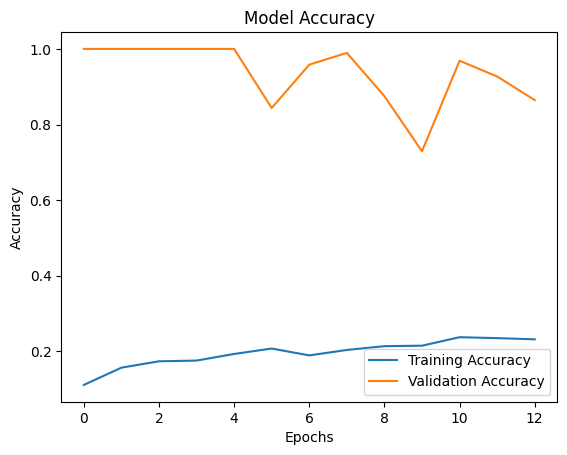

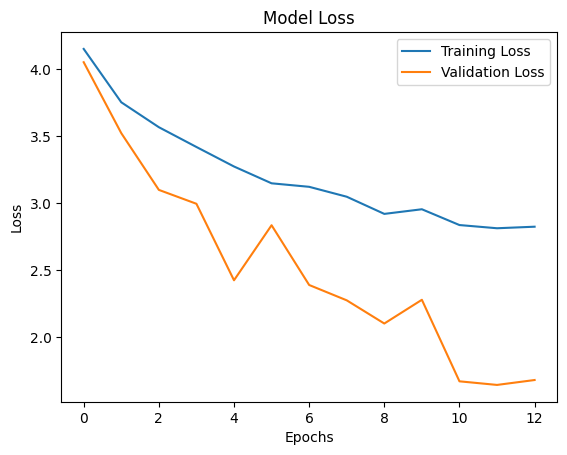

In [70]:
# 绘制准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [71]:
class_indices = {v: k for k, v in enumerate(style_val_data['class_index'].unique())}
class_names = list(class_indices.keys())

In [72]:
print(f"最大真实标签值: {max(y_true)}")
print(f"最大预测标签值: {max(y_pred)}")


最大真实标签值: 26
最大预测标签值: 24


In [73]:
# 计算哪些图像被错误分类
incorrect_idx = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

# 获取类别名称
if isinstance(val_gen, ImageLabelGenerator):
    class_names = list(val_gen.class_indices.keys())
else:
    # 手动指定类别名称
    # 设定正确的类别名称（假设有 27 个类别）
    class_names = [
    '0', '1', '2', '3', '4', '5', '6', 
    '7', '8', '9', '10', '11', '12', '13', 
    '14', '15', '16', '17', '18', '19', '20', 
    '21', '22', '23', '24', '25', '26'
]

In [74]:
# 3. 计算并打印分类报告
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.18      0.07      0.10       834
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        33
           3       0.25      0.11      0.16      1300
           4       0.35      0.14      0.20      1272
           5       0.45      0.23      0.31       484
           6       0.00      0.00      0.00       144
           7       0.00      0.00      0.00       670
           8       0.00      0.00      0.00       417
           9       0.14      0.04      0.07      2020
          10       0.00      0.00      0.00       280
          11       0.00      0.00      0.00       402
          12       0.15      0.90      0.25      2446
          13       0.00      0.00      0.00       383
          14       0.66      0.10      0.18       401
          15       0.00      0.00      0.00       716
          16       0.00      0.00      0.00        94
          17       0.00    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

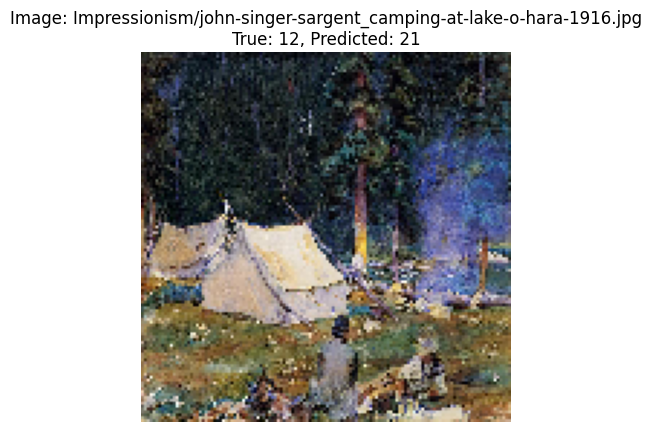

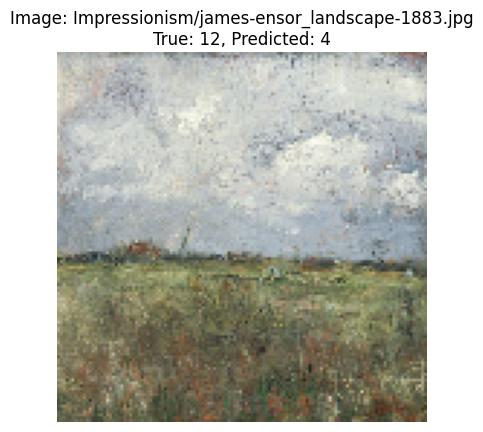

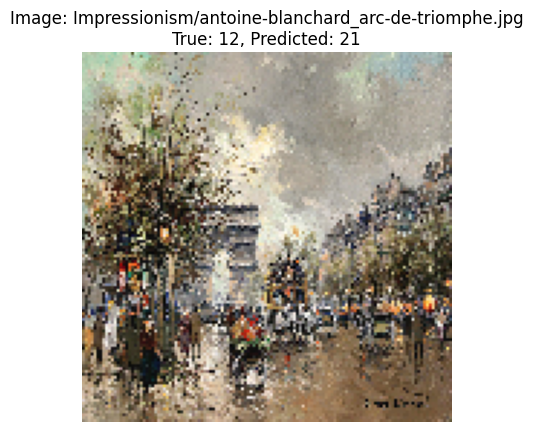

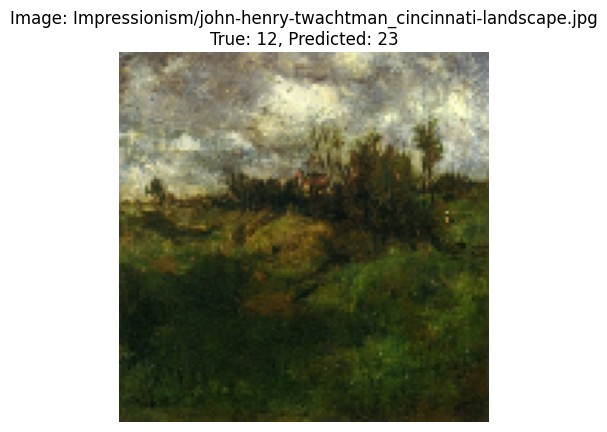

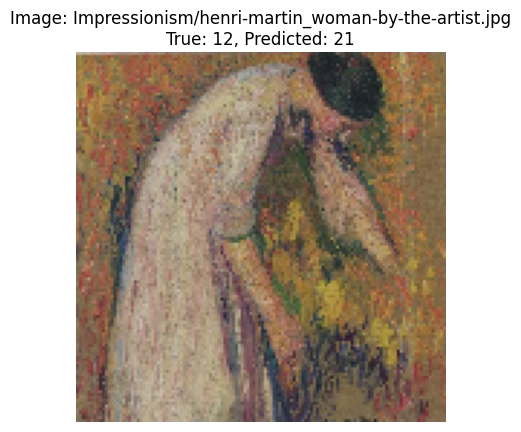

In [75]:
# 查看前 5 个错误分类的图像
for idx in incorrect_idx[:5]:
    img_path = os.path.join(data_dir, style_val_data.iloc[idx]['image_path'])
    img_name = style_val_data.iloc[idx]['image_path']
    img = load_img(img_path, target_size=img_size)
    plt.imshow(img)
    true_label = class_names[y_true[idx]]
    predicted_label = class_names[y_pred[idx]]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.title(f"Image: {img_name}\nTrue: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    plt.pause(0.1)  # 让显示过程有一个小的延迟，确保图像渲染


In [76]:
# model.save('ConvLSTM_model.h5')

# # 确保模型已编译
# model = load_model('ConvLSTM_model.h5')
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [77]:
# 进行一次预测以确保模型的输入已被初始化
# _ = model.predict(train_gen, batch_size=batch_size)

# # 确保层名称正确
# print("Model Layers:")
# for layer in model.layers:
#     print(layer.name)

# # 提取中间层的特征
# feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv2d_3').output)

# #提取训练集和验证集的特征
# train_features = feature_extractor.predict(train_gen, batch_size=batch_size)
# val_features = feature_extractor.predict(val_gen, batch_size=batch_size)

# # 标准化特征
# train_features = normalize(train_features.reshape(train_features.shape[0], -1))  # 扁平化并标准化
# val_features = normalize(val_features.reshape(val_features.shape[0], -1))

# # 存储文件名以便后续可视化
# train_filenames = train_gen.filenames
# val_filenames = val_gen.filenames


In [78]:
# # 3. 从训练集提取特征 (假设 train_gen 是您的数据生成器)
# features = []
# labels = []

# for batch_images, batch_labels in train_gen:
#     # 提取特征
#     batch_features = feature_extractor.predict(batch_images)
#     batch_features = batch_features.reshape(batch_features.shape[0], -1)  # 展平特征
#     features.append(batch_features)
#     labels.append(batch_labels)

# # 转换为 numpy 数组
# features = np.vstack(features)
# labels = np.concatenate(labels)

# # 4. 使用 PCA 进行降维 (2D)
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(features)

# # 5. 使用 Isolation Forest 进行异常检测
# clf = IsolationForest(n_estimators=100, contamination=0.1)  # 假设 10% 是异常点
# outliers = clf.fit_predict(reduced_features)  # 返回 1 表示正常，-1 表示异常

# # 找到异常的索引
# outlier_indices = np.where(outliers == -1)[0]

# # 6. 可视化
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', label='Normal')
# plt.scatter(reduced_features[outlier_indices, 0], reduced_features[outlier_indices, 1], c='red', label='Outliers')
# plt.legend()
# plt.title("PCA Visualization with Outliers")
# plt.show()

# # 7. 打印异常画作的名字 (或索引)
# print("异常画作的索引:", outlier_indices)


In [79]:
# def pictures(test_idx):
#     test_feature = val_features[test_idx].reshape(1, -1)
#     my_distance = cdist(test_feature, train_features, metric='euclidean')[0]
#     nearest_neighbors_idx = np.argpartition(my_distance, 5)[:5]
    
#     plt.figure(figsize=(8, 8))     
#     plt.subplot(2, 3, 1)
#     img = plt.imread(os.path.join(data_dir, style_val_data.iloc[test_idx]['image_path']))
#     plt.imshow(img)
#     plt.title(f"Test Image: {style_val_data.iloc[test_idx]['image_path']}")
#     plt.axis('off')
    
#     for p in range(len(nearest_neighbors_idx)):
#         plt.subplot(2, 3, p + 2)
#         neighbor_image = plt.imread(os.path.join(data_dir, style_val_data.iloc[nearest_neighbors_idx[p]]['image_path']))
#         plt.imshow(neighbor_image)
#         plt.title(f"Neighbor {p+1}")
#         plt.axis('off')
    
#     plt.show()


In [80]:
# # 加载模型
# model = load_model('ConvLSTM_model.h5')

# # 打印模型的层，确保它已正确加载
# model.summary()

# # 检查所有层的名称
# for layer in model.layers:
#     print(f"Layer Name: {layer.name}")

# # 假设输入的形状是 (batch_size, time_steps, height, width, channels)
# dummy_input = np.random.random((1, 1, 128, 128, 3))  # 模拟输入数据

# # 激活模型进行前向传播，确保每层都有正确的输入
# model.predict(dummy_input)

# # 获取 'conv2d_1' 层并创建新模型
# conv2d_1_layer = model.get_layer('conv2d_1')  # 获取目标层
# model2 = Model(inputs=model.inputs, outputs=conv2d_1_layer.output)  # 使用 model.inputs

# # 查看提取模型的结构
# model2.summary()

# # 进行预测以获取 'conv2d_1' 层的输出
# output = model2.predict(dummy_input)
# print(output.shape)  # 打印输出形状


In [81]:
# # 通过CNN提取的特征
# # 示例：画作特征数据的模拟
# features = np.random.rand(100, 128)  # 100个画作，每个画作有128个特征

# # 标准化特征数据
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # PCA降维到2D
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(features_scaled)

# # 使用K-means进行聚类
# kmeans = KMeans(n_clusters=3, random_state=42)
# kmeans.fit(reduced_features)
# labels = kmeans.labels_

# # 计算每个点到其所属簇中心的距离（距离越大，越可能是异常值）
# distances = np.linalg.norm(reduced_features - kmeans.cluster_centers_[labels], axis=1)

# # 假设距离大于某个阈值的点为异常点
# threshold = np.percentile(distances, 95)  # 取95%分位数作为阈值
# outliers = np.where(distances > threshold)[0]

# # 可视化
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
# plt.scatter(reduced_features[outliers, 0], reduced_features[outliers, 1], color='red', label='Outliers')
# plt.legend()
# plt.title('PCA and K-means Outlier Detection')
# plt.show()

# print("异常点的索引:", outliers)
